In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from PIL import Image

class TinyImageNetLoader(Dataset):
    def __init__(self, root_dir, split='train', transform=None, num_classes=20):
        self.root_dir = root_dir
        self.transform = transform
        self.num_classes = num_classes
        self.split = split

        # Create a list of all image file paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Determine the subdirectory based on the split ('train' or 'val')
        if split == 'train' or split == 'test':
            data_dir = 'train'
            label_file = 'wnids.txt'
        elif split == 'val':
            data_dir = 'val/images'
            label_file = 'val_annotations.txt'
        else:
            raise ValueError("Invalid 'split' value. Use 'train', 'val' or 'test'.")

        # Load class names and labels from the 'wnids.txt' file
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            class_names = f.read().splitlines()[:num_classes]

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i

        # Load image file paths and labels for each class
        if split == 'train':
            for class_name, class_idx in self.class_to_idx.items():
                class_dir = os.path.join(root_dir, data_dir, class_name, 'images')
                image_files = os.listdir(class_dir)
                index = 0
                for image_file in image_files:
                    #we keep the firsts 450 images for train
                    if index == 450:
                        break
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
                    index+=1
        elif split == 'test':
            for class_name, class_idx in self.class_to_idx.items():
                class_dir = os.path.join(root_dir, data_dir, class_name, 'images')
                image_files = os.listdir(class_dir)
                index = 0
                for image_file in image_files:
                    #we keep the last 50 images for test
                    if index < 450:
                        index+=1
                        continue
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
        elif split == 'val':
            with open(os.path.join(root_dir, 'val', 'val_annotations.txt'), 'r') as f:
                lines = f.read().splitlines()
                for line in lines:
                    parts = line.split('\t')
                    image_path = os.path.join(root_dir, data_dir, parts[0])
                    class_name = parts[1]
                    if class_name in class_names:
                        class_idx = self.class_to_idx[class_name]
                        self.image_paths.append(image_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)  # Convert label to tensor

        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Convert the image to a tensor
])

# Specify the number of classes you want (e.g., 20)
num_classes = 20
batch_size = 32

tinyimagenet_dataset_train = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='train', transform=transform, num_classes=num_classes)
tinyimagenet_dataset_val = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='val', transform=transform, num_classes=num_classes)
tinyimagenet_dataset_test = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='test', transform=transform, num_classes=num_classes)
data_train = DataLoader(tinyimagenet_dataset_train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(tinyimagenet_dataset_val, batch_size=batch_size, shuffle=True)
data_test = DataLoader(tinyimagenet_dataset_test, batch_size=batch_size, shuffle=True)

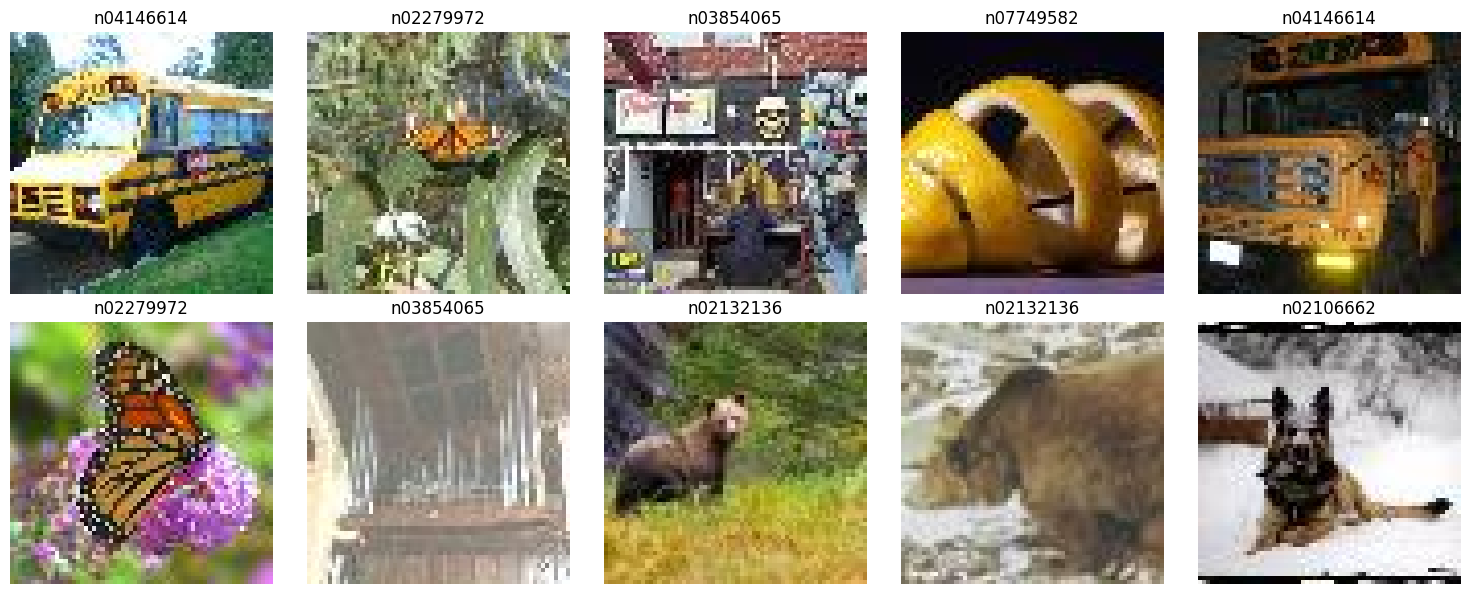

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np

def show_examples(dataset):
    # Get 10 random indices from the dataset
    random_indices = random.sample(range(len(dataset)), 10)

    # Create a subplot for each image
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]

        # Get the class name corresponding to the label
        class_name = [k for k, v in dataset.class_to_idx.items() if v == label][0]

        # Convert the PyTorch tensor to a NumPy array for display
        image = np.array(image).transpose((1, 2, 0))

        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_examples(tinyimagenet_dataset_test)

# Pipeline preparation

In [5]:
import torch
import numpy as np

def val(model, data_val, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_accuracy = 0.0
    num_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_val):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_accuracy += correct
            num_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    average_test_loss = total_loss / len(data_val)
    accuracy = (total_accuracy / num_samples) * 100

    #print(f'Average Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return all_labels, all_predictions, average_test_loss, accuracy


In [6]:
def test(model, data_test, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(data_test.dataset)
    accuracy = 100 * correct / len(data_test.dataset)

    return test_loss, accuracy, all_labels, all_preds

In [7]:
def plot_history(epochs, train_losses, train_accuracies, val_losses, val_accuracies):
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(all_labels, all_predictions):
    confusion = confusion_matrix(all_labels, all_predictions)
    # Create a heatmap of the confusion matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)

    # Customize the plot (labels, title, etc.)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
import torch
import matplotlib.pyplot as plt

def pipeline(epochs, model, data_train, data_val, data_test, optimizer, criterion, device, stats=True):
    
    #return the best_model according to the best val_accuracy
    best_model = model.state_dict()
    best_val_accuracy = 0
    
    all_labels, all_preds = None, None

    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(data_train):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        average_loss = running_loss / len(data_train)
        training_losses.append(average_loss)

        accuracy = 100 * correct / total
        training_accuracies.append(accuracy)
        
        all_labels, all_preds, val_loss, val_accuracy = val(model, data_val, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()
            
        print(f'Epoch [{epoch + 1}/{epochs}], train_loss: {average_loss:.2f}, train_accuracy: {accuracy:.2f}%, val_loss: {val_loss:.2f}, val_accuracy: {val_accuracy:.2f}%')

    print('Training complete')
    
    #we keep the best model
    model.load_state_dict(best_model)
    
    if stats:
        
        plot_history(epochs, training_losses, training_accuracies, val_losses, val_accuracies)

        test_loss, test_accuracy, all_labels, all_preds = test(model, data_test, criterion, device)
        print(f'Test loss: {test_loss:.2f}, Test accuracy: {test_accuracy:.2f}%')

        conf_matrix(all_labels, all_preds)
    
    return model

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

epochs = 20

Using cuda device


# Exercise 2

In [11]:
import torch.optim as optim

# Créer un modèle ConvNet
class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Nombre de neurones dans la 1ère couche dense
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


model = ConvNet().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)


Epoch [1/20], train_loss: 2.94, train_accuracy: 9.21%, val_loss: 2.85, val_accuracy: 13.00%
Epoch [2/20], train_loss: 2.73, train_accuracy: 17.17%, val_loss: 2.72, val_accuracy: 17.90%
Epoch [3/20], train_loss: 2.53, train_accuracy: 23.42%, val_loss: 2.49, val_accuracy: 25.00%
Epoch [4/20], train_loss: 2.38, train_accuracy: 28.81%, val_loss: 2.38, val_accuracy: 27.40%
Epoch [5/20], train_loss: 2.25, train_accuracy: 32.41%, val_loss: 2.23, val_accuracy: 32.10%
Epoch [6/20], train_loss: 2.13, train_accuracy: 35.78%, val_loss: 2.28, val_accuracy: 31.80%
Epoch [7/20], train_loss: 2.04, train_accuracy: 39.12%, val_loss: 2.20, val_accuracy: 34.30%
Epoch [8/20], train_loss: 1.96, train_accuracy: 41.27%, val_loss: 3.15, val_accuracy: 14.60%
Epoch [9/20], train_loss: 1.89, train_accuracy: 43.90%, val_loss: 2.24, val_accuracy: 33.20%
Epoch [10/20], train_loss: 1.82, train_accuracy: 45.72%, val_loss: 2.15, val_accuracy: 36.20%
Epoch [11/20], train_loss: 1.75, train_accuracy: 47.31%, val_loss: 2.3

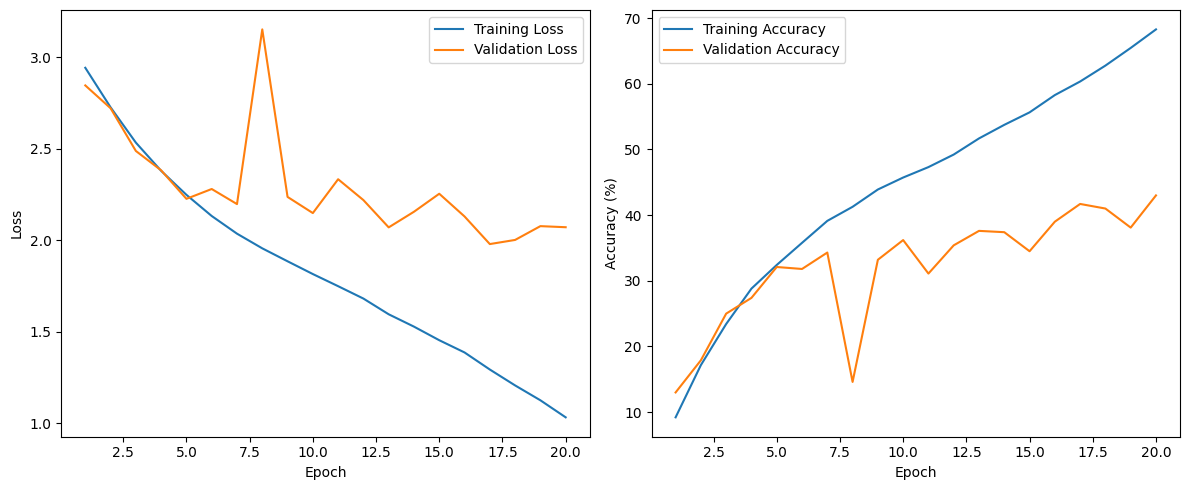

Test loss: 0.06, Test accuracy: 43.50%


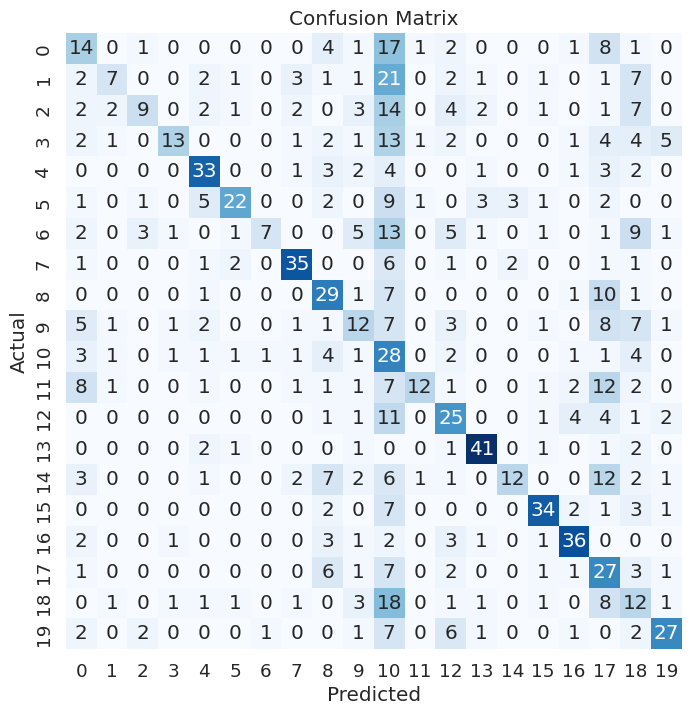

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

In [12]:
pipeline(epochs, model, data_train, data_val, data_test, optimizer, criterion, device)

# Exercise 3

In [13]:
# Créer un modèle ConvNet
class ConvNet2(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*4*4, 1000)  # Nombre de neurones dans la 1ère couche dense
        self.fc2 = nn.Linear(1000, num_classes)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        #print(x.shape)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model2 = ConvNet2().to(device)
print(model2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01)

ConvNet2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=20, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
)


Epoch [1/20], train_loss: 2.42, train_accuracy: 27.69%, val_loss: 3.74, val_accuracy: 16.70%
Epoch [2/20], train_loss: 1.83, train_accuracy: 44.80%, val_loss: 2.64, val_accuracy: 25.90%
Epoch [3/20], train_loss: 1.59, train_accuracy: 51.54%, val_loss: 1.93, val_accuracy: 42.50%
Epoch [4/20], train_loss: 1.43, train_accuracy: 56.00%, val_loss: 1.85, val_accuracy: 45.60%
Epoch [5/20], train_loss: 1.31, train_accuracy: 59.78%, val_loss: 1.80, val_accuracy: 46.40%
Epoch [6/20], train_loss: 1.19, train_accuracy: 63.30%, val_loss: 1.77, val_accuracy: 49.80%
Epoch [7/20], train_loss: 1.07, train_accuracy: 67.33%, val_loss: 1.98, val_accuracy: 45.40%
Epoch [8/20], train_loss: 0.98, train_accuracy: 69.97%, val_loss: 2.34, val_accuracy: 39.10%
Epoch [9/20], train_loss: 0.88, train_accuracy: 73.31%, val_loss: 1.60, val_accuracy: 52.40%
Epoch [10/20], train_loss: 0.79, train_accuracy: 75.99%, val_loss: 1.60, val_accuracy: 53.40%
Epoch [11/20], train_loss: 0.69, train_accuracy: 79.53%, val_loss: 3.

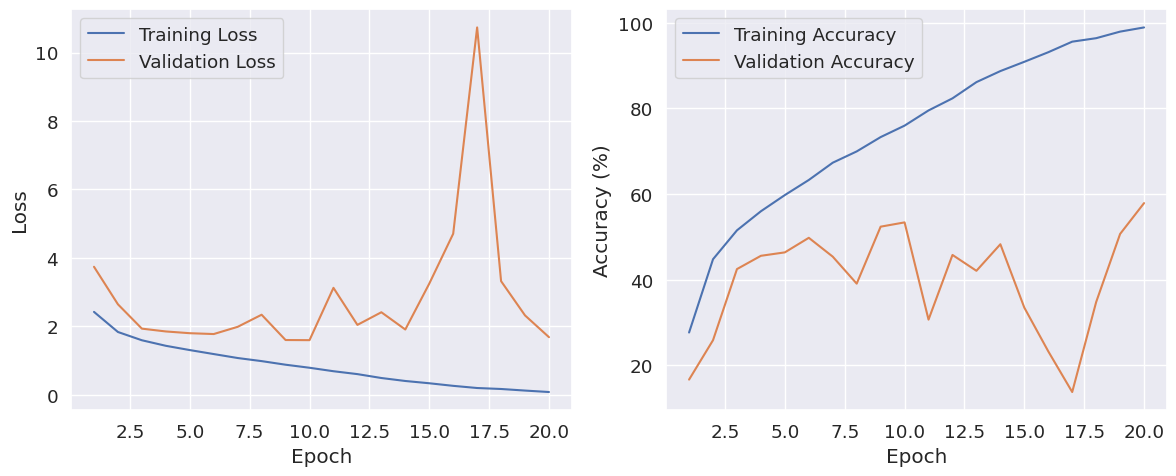

Test loss: 0.05, Test accuracy: 59.30%


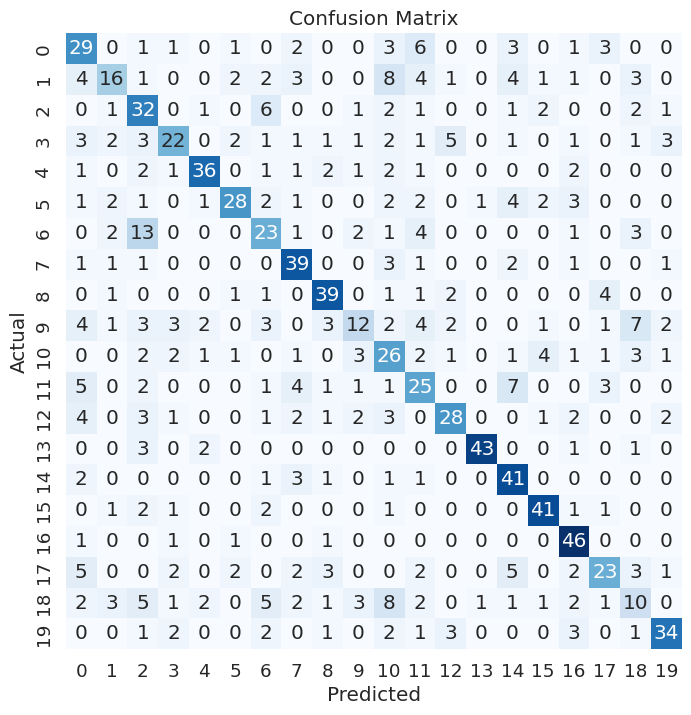

ConvNet2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=20, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [14]:
pipeline(epochs, model2, data_train, data_val, data_test, optimizer, criterion, device)

# exercise 4

In [152]:
# Créer un modèle ConvNet
class ConvNet3(nn.Module):
    def __init__(self, device, conv_layer_size, linear_layer_size, kernel_size, in_channels=3):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv_layer_size, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_layer_size)
        
        self.conv2 = nn.Conv2d(conv_layer_size, conv_layer_size*2, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_layer_size*2)
        
                
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.linear_layer_size = linear_layer_size
        self.device = device

    def forward(self, x):
        
        x = self.pool(self.relu(self.bn1(self.conv1(x.to(self.device)))))
        x = self.pool(self.relu(self.bn2(self.conv2(x.to(self.device)))))
        x = self.flatten(x)
        x = self.relu(nn.Linear(x.shape[1], self.linear_layer_size).to(self.device)(x))
        x = self.dropout(x)
        x = nn.Linear(self.linear_layer_size, num_classes).to(self.device)(x)
                      
        return x


In [148]:
import itertools

hyperparameter_space = {
    #'learning_rate': [0.01, 0.001],
    #'dropout': [0.25, 0.5],
    'conv_layer_size': [32, 64],
    'linear_layer_size': [512, 1024],
    'kernel_size': [3, 5]
}

hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

In [150]:
def tune(hyperparameter_combinations):
    best_model = None
    best_accuracy = 0

    for params in hyperparameter_combinations:
        conv_layer_size, linear_layer_size, kernel_size = params
        
        print(params)

        # Create a new model with the specified hyperparameters
        model = ConvNet3(device, conv_layer_size, linear_layer_size, kernel_size, in_channels=3).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        # Train the model using the pipeline function
        best_trained_model = pipeline(7, model, data_train, data_val, data_test, optimizer, criterion, device, stats = False)

        # Evaluate the model on the validation set
        _, _, _, val_accuracy = val(best_trained_model, data_val, criterion, device)

        # Check if this model has the best validation accuracy
        if val_accuracy > best_accuracy:
            best_model = best_trained_model
            best_accuracy = val_accuracy
        
    return best_model

In [ ]:
best_model = tune(hyperparameter_combinations)

# Exercise 5

In [15]:
num_classes = 40

tinyimagenet_dataset_train_40 = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='train', transform=transform, num_classes=num_classes)
tinyimagenet_dataset_val_40 = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='val', transform=transform, num_classes=num_classes)
tinyimagenet_dataset_test_40 = TinyImageNetLoader(root_dir='/kaggle/input/tiny-imagenet/tiny-imagenet-200', split='test', transform=transform, num_classes=num_classes)
data_train_40 = DataLoader(tinyimagenet_dataset_train_40, batch_size=batch_size, shuffle=True)
data_val_40 = DataLoader(tinyimagenet_dataset_val_40, batch_size=batch_size, shuffle=True)
data_test_40 = DataLoader(tinyimagenet_dataset_test_40, batch_size=batch_size, shuffle=True)

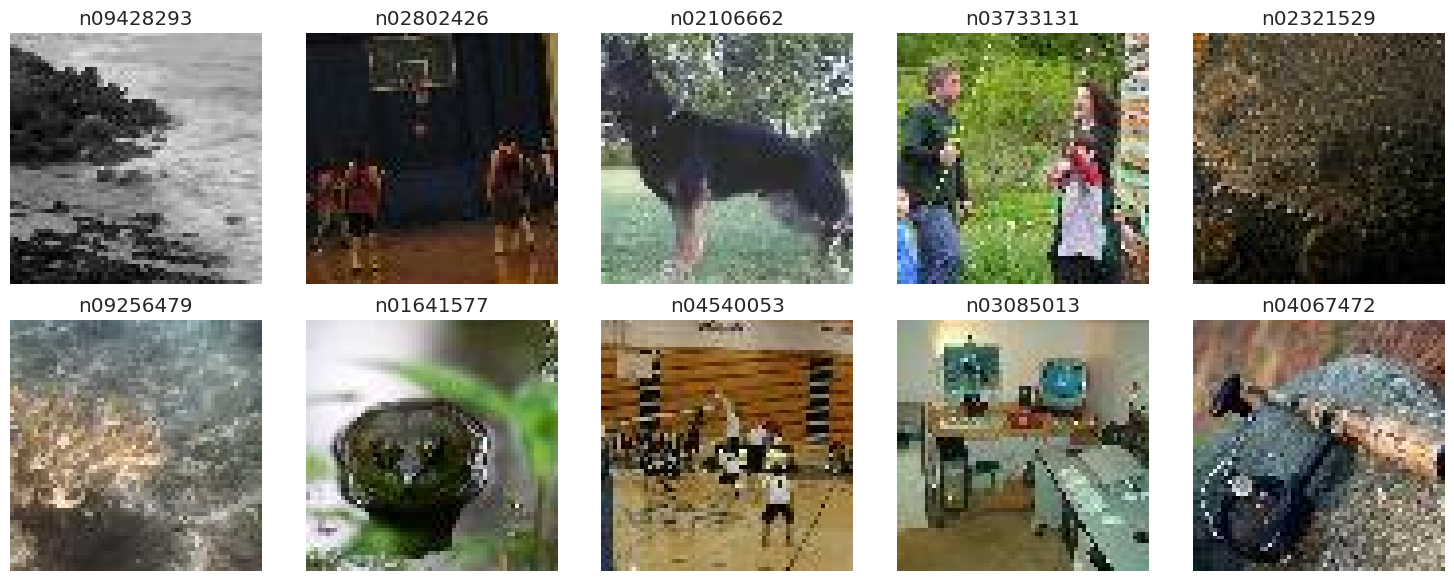

In [16]:
show_examples(tinyimagenet_dataset_train_40)

In [17]:
# Créer un modèle ConvNet
class ConvNet4(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*4*4, 1000)  # Nombre de neurones dans la 1ère couche dense
        self.fc2 = nn.Linear(1000, num_classes)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        #print(x.shape)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model4 = ConvNet4().to(device)
print(model4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(), lr=0.01)

ConvNet4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=40, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
)


Epoch [1/20], train_loss: 3.08, train_accuracy: 18.24%, val_loss: 3.59, val_accuracy: 9.60%
Epoch [2/20], train_loss: 2.44, train_accuracy: 33.68%, val_loss: 2.53, val_accuracy: 31.45%
Epoch [3/20], train_loss: 2.15, train_accuracy: 40.47%, val_loss: 2.50, val_accuracy: 32.45%
Epoch [4/20], train_loss: 1.97, train_accuracy: 44.64%, val_loss: 2.50, val_accuracy: 33.50%
Epoch [5/20], train_loss: 1.82, train_accuracy: 48.56%, val_loss: 2.32, val_accuracy: 35.60%
Epoch [6/20], train_loss: 1.68, train_accuracy: 52.42%, val_loss: 2.01, val_accuracy: 44.15%
Epoch [7/20], train_loss: 1.57, train_accuracy: 55.03%, val_loss: 2.02, val_accuracy: 44.25%
Epoch [8/20], train_loss: 1.45, train_accuracy: 58.31%, val_loss: 2.29, val_accuracy: 39.25%
Epoch [9/20], train_loss: 1.34, train_accuracy: 61.42%, val_loss: 2.74, val_accuracy: 31.15%
Epoch [10/20], train_loss: 1.23, train_accuracy: 64.48%, val_loss: 2.18, val_accuracy: 42.50%
Epoch [11/20], train_loss: 1.11, train_accuracy: 67.75%, val_loss: 2.2

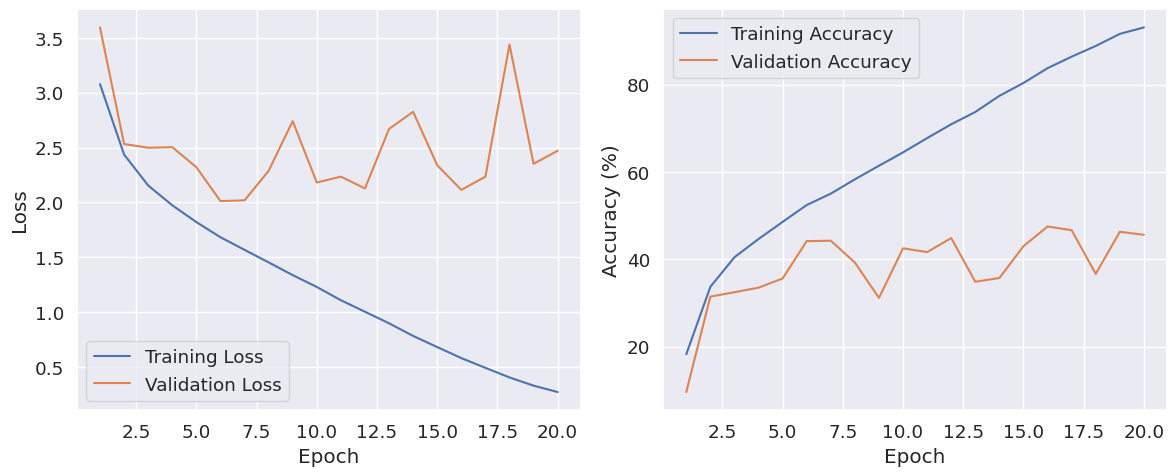

Test loss: 0.08, Test accuracy: 42.60%


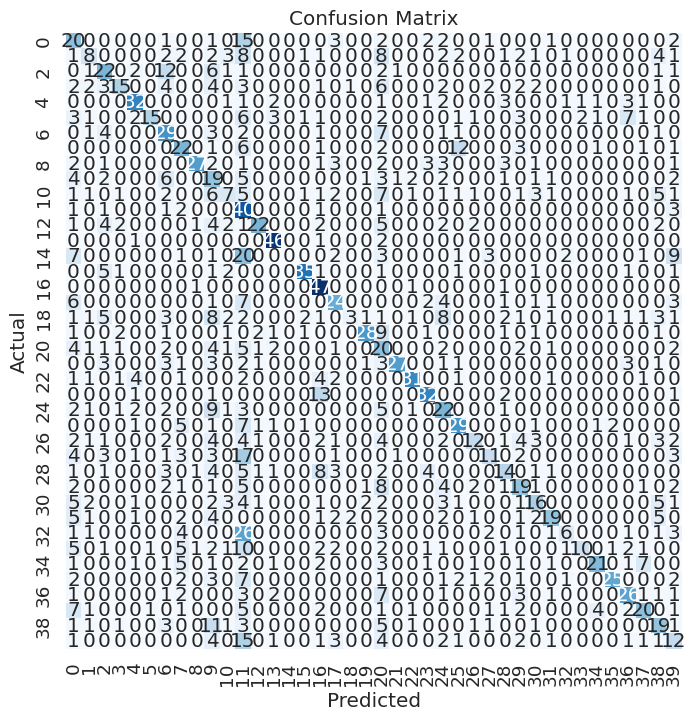

In [18]:
best_model = pipeline(epochs, model4, data_train_40, data_val_40, data_test_40, optimizer, criterion, device)

Le modèle semble être toujours adapter pour 40 classes, en effet les resultats obtenus ne sont pas trop eloignés des résultats obtenus avec 20 classes.